In [ ]:
!unzip /content/drive/MyDrive/BigData/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20250501.zip -d /content/drive/MyDrive/BigData/Hospital_Inpatient_Discharges__SPARCS


Archive:  /content/drive/MyDrive/BigData/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20250501.zip
replace /content/drive/MyDrive/BigData/Hospital_Inpatient_Discharges__SPARCS/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20250501.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data = "/content/drive/MyDrive/BigData/Hospital_Inpatient_Discharges__SPARCS/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20250501.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics         import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration     import calibration_curve
from imblearn.over_sampling  import SMOTE
from xgboost                 import XGBClassifier


# LOAD CSV

In [ ]:
df = pd.read_csv(data)

<ipython-input-7-dfb1afbad684>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data)


In [ ]:
print("Sample shape:", df.shape)

Sample shape: (2343429, 34)


In [ ]:
df.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,Private Health Insurance,NaN,0,N,N,3913.23,3466.83
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,M,White,Not Span/Hispanic,...,Minor,Medical,Self-Pay,NaN,NaN,0,N,Y,3597.10,3746.80
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Federal/State/Local/VA,NaN,0,N,Y,9149.22,8322.10
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,Medicaid,NaN,0,N,Y,5880.61,5828.87
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,M,White,Not Span/Hispanic,...,Moderate,Medical,Blue Cross/Blue Shield,NaN,NaN,0,N,Y,7019.76,6604.00


In [ ]:
df.dtypes

,0
Health Service Area,object
Hospital County,object
Operating Certificate Number,float64
Facility Id,float64
Facility Name,object
Age Group,object
Zip Code - 3 digits,object
Gender,object
Race,object
Ethnicity,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343429 entries, 0 to 2343428
Data columns (total 34 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Health Service Area                  object 
 1   Hospital County                      object 
 2   Operating Certificate Number         float64
 3   Facility Id                          float64
 4   Facility Name                        object 
 5   Age Group                            object 
 6   Zip Code - 3 digits                  object 
 7   Gender                               object 
 8   Race                                 object 
 9   Ethnicity                            object 
 10  Length of Stay                       object 
 11  Type of Admission                    object 
 12  Patient Disposition                  object 
 13  Discharge Year                       int64  
 14  CCS Diagnosis Code                   int64  
 15  CCS Diagnosis Description       

# Global Cleaning

In [ ]:
# Count of missing values per column
missing_counts = df.isnull().sum()

# Percentage of missing values per column
missing_percent = (df.isnull().mean() * 100).round(2)

# Combine into one DataFrame and sort by highest percent missing
missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)

display(missing_df)

,missing_count,missing_percent
Payment Typology 3,1691076,72.16
Payment Typology 2,834420,35.61
Zip Code - 3 digits,36215,1.55
Health Service Area,5325,0.23
Hospital County,5325,0.23
Operating Certificate Number,5325,0.23
Facility Id,5325,0.23
Gender,0,0.00
Age Group,0,0.00
Facility Name,0,0.00


In [ ]:

#  Drop unneeded columns
to_drop = [
    "Operating Certificate Number", "Facility Id", "Facility Name",
    "CCS Diagnosis Description", "CCS Procedure Description",
    "APR DRG Description", "APR MDC Description",
    "APR Severity of Illness Description",
    "APR Medical Surgical Description",
    "Payment Typology 3", "Discharge Year",
    "Birth Weight", "Abortion Edit Indicator"
]
df = df.drop(columns=to_drop)

# Impute the sparse-but-important fields
df["Zip Code - 3 digits"]          = df["Zip Code - 3 digits"].fillna("000")
df["Payment Typology 2"]           = df["Payment Typology 2"].fillna("Unknown")

# Fill Health Service Area & Hospital County with "Unknown"
df["Health Service Area"] = df["Health Service Area"].fillna("Unknown")
df["Hospital County"]     = df["Hospital County"].fillna("Unknown")

# Verify
print(df.shape)
df.isna().mean().round(3).sort_values(ascending=False).head(5)


(2343429, 21)


,0
Health Service Area,0.0
Hospital County,0.0
Age Group,0.0
Zip Code - 3 digits,0.0
Gender,0.0


Removed columns like facility IDs, long text descriptions, and very sparse fields because they don’t help the model, then filled any missing ZIP codes with “000” and blank payment or location fields with “Unknown” so I could keep all those rows and let “missing” be its own category.

In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Health Service Area                0
Hospital County                    0
Age Group                          0
Zip Code - 3 digits                0
Gender                             0
Race                               0
Ethnicity                          0
Length of Stay                     0
Type of Admission                  0
Patient Disposition                0
CCS Diagnosis Code                 0
CCS Procedure Code                 0
APR DRG Code                       0
APR MDC Code                       0
APR Severity of Illness Code       0
APR Risk of Mortality             67
Payment Typology 1                 0
Payment Typology 2                 0
Emergency Department Indicator     0
Total Charges                      0
Total Costs                        0
dtype: int64


In [ ]:
mode_rom = df["APR Risk of Mortality"].mode()[0]
df["APR Risk of Mortality"] = df["APR Risk of Mortality"].fillna(mode_rom)

Replaced any missing “APR Risk of Mortality” entries with the most frequent category so that every patient record has a valid risk label, avoiding drops in data and keeping the dataset complete for modeling.

In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Health Service Area               0
Hospital County                   0
Age Group                         0
Zip Code - 3 digits               0
Gender                            0
Race                              0
Ethnicity                         0
Length of Stay                    0
Type of Admission                 0
Patient Disposition               0
CCS Diagnosis Code                0
CCS Procedure Code                0
APR DRG Code                      0
APR MDC Code                      0
APR Severity of Illness Code      0
APR Risk of Mortality             0
Payment Typology 1                0
Payment Typology 2                0
Emergency Department Indicator    0
Total Charges                     0
Total Costs                       0
dtype: int64


In [ ]:
# Count how many exact duplicates exist
dup_count = df.duplicated().sum()
print(f"Found {dup_count} duplicate rows")

# Drop all exact duplicates in place
df = df.drop_duplicates()

# Verify they’re gone
print("Rows after dropping duplicates:", df.shape[0])


Found 29543 duplicate rows
Rows after dropping duplicates: 2313886


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Count NaNs per column
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0])

# Drop rows with NaN in specific critical columns
df = df.dropna(subset=["Age Group", "Length of Stay"])

# Fill NaN in other columns with a placeholder or aggregate
df["Zip Code - 3 digits"]    = df["Zip Code - 3 digits"].fillna("000")
df["Payment Typology 2"]     = df["Payment Typology 2"].fillna("Unknown")

# Verify no NaNs remain
print(df.isna().sum().sort_values(ascending=False).head())


Series([], dtype: int64)
Health Service Area    0
Hospital County        0
Age Group              0
Zip Code - 3 digits    0
Gender                 0
dtype: int64


In [ ]:
#  Confirm zero duplicates
print("Duplicates left:", df.duplicated().sum())

#  Confirm zero NaNs in kept columns
print(df.isna().sum()[df.isna().sum() > 0])


Duplicates left: 0
Series([], dtype: int64)


# VISUALIZATION

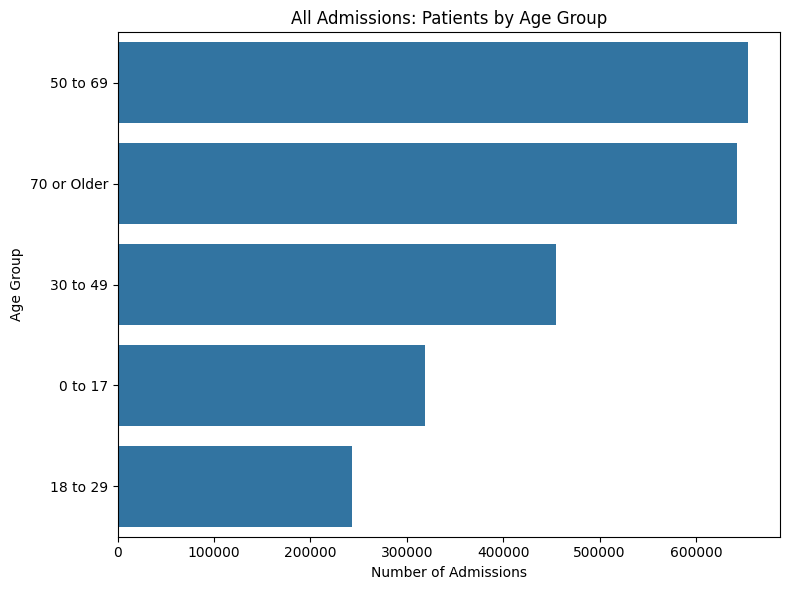

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(
    y="Age Group",
    data=df,
    order=df["Age Group"].value_counts().index
)
plt.title("All Admissions: Patients by Age Group")
plt.xlabel("Number of Admissions")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2313886 entries, 0 to 2343428
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Health Service Area             object 
 1   Hospital County                 object 
 2   Age Group                       object 
 3   Zip Code - 3 digits             object 
 4   Gender                          object 
 5   Race                            object 
 6   Ethnicity                       object 
 7   Length of Stay                  object 
 8   Type of Admission               object 
 9   Patient Disposition             object 
 10  CCS Diagnosis Code              int64  
 11  CCS Procedure Code              int64  
 12  APR DRG Code                    int64  
 13  APR MDC Code                    int64  
 14  APR Severity of Illness Code    int64  
 15  APR Risk of Mortality           object 
 16  Payment Typology 1              object 
 17  Payment Typology 2              

<ipython-input-24-e03c0a5fc750>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Length of Stay"] = df["Length of Stay"].astype(int)


New dtype: int64
0    3
1    2
2    7
3    4
4    5
Name: Length of Stay, dtype: int64


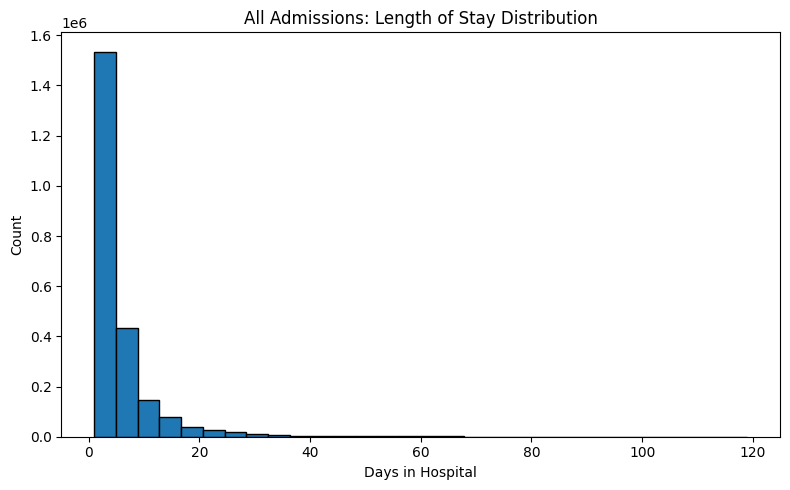

In [ ]:
# Convert to numeric (coerce any bad strings to NaN)
df["Length of Stay"] = pd.to_numeric(df["Length of Stay"], errors="coerce")

#  Drop any rows where conversion failed (should be none)
df = df.dropna(subset=["Length of Stay"])

# Cast to integer
df["Length of Stay"] = df["Length of Stay"].astype(int)

# Confirm dtype
print("New dtype:", df["Length of Stay"].dtype)
print(df["Length of Stay"].head())

#  Re-plot with Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["Length of Stay"], bins=30, edgecolor="k")
plt.title("All Admissions: Length of Stay Distribution")
plt.xlabel("Days in Hospital")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Converted the “Length of Stay” column from text to numbers (coercing any bad strings to NaN), dropped the few rows that couldn’t convert, cast the results to integers, and then plotted a histogram so I could see the distribution of hospital stay lengths

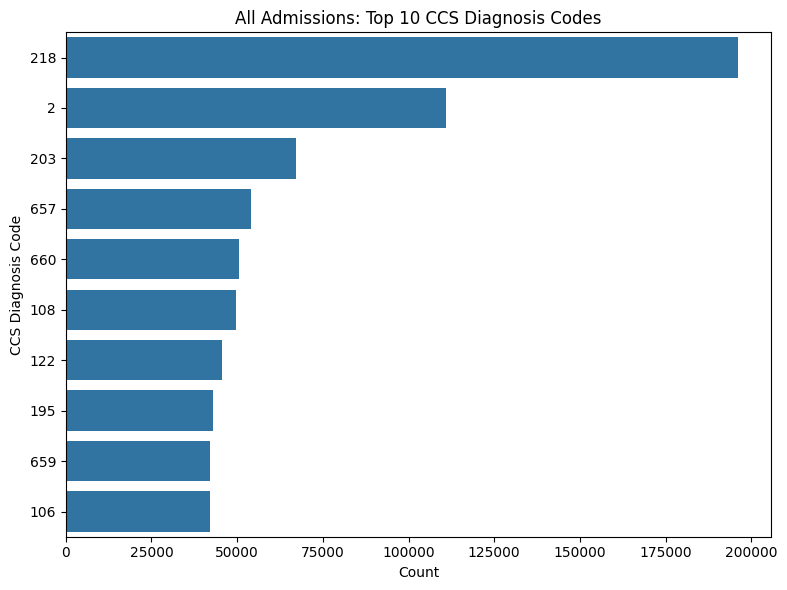

In [ ]:
top10 = df["CCS Diagnosis Code"].value_counts().nlargest(10)
plt.figure(figsize=(8,6))
sns.barplot(
    x=top10.values,
    y=top10.index.astype(str),
    orient="h"
)
plt.title("All Admissions: Top 10 CCS Diagnosis Codes")
plt.xlabel("Count")
plt.ylabel("CCS Diagnosis Code")
plt.tight_layout()
plt.show()


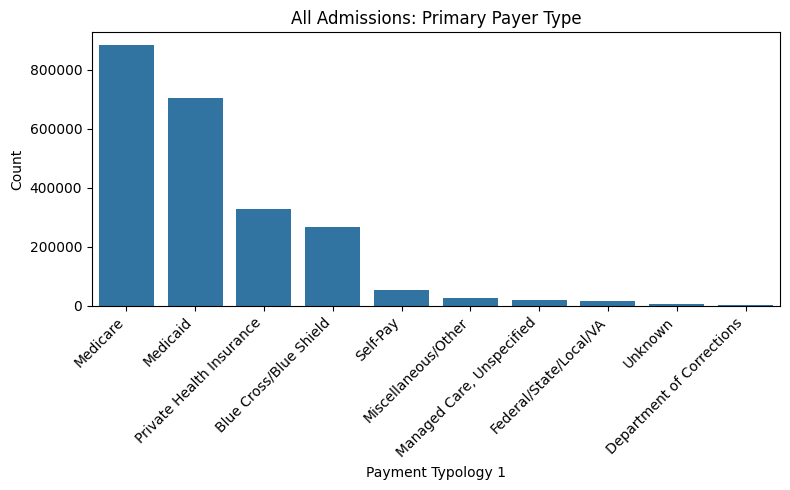

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    x="Payment Typology 1",
    data=df,
    order=df["Payment Typology 1"].value_counts().index
)
plt.title("All Admissions: Primary Payer Type")
plt.xlabel("Payment Typology 1")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


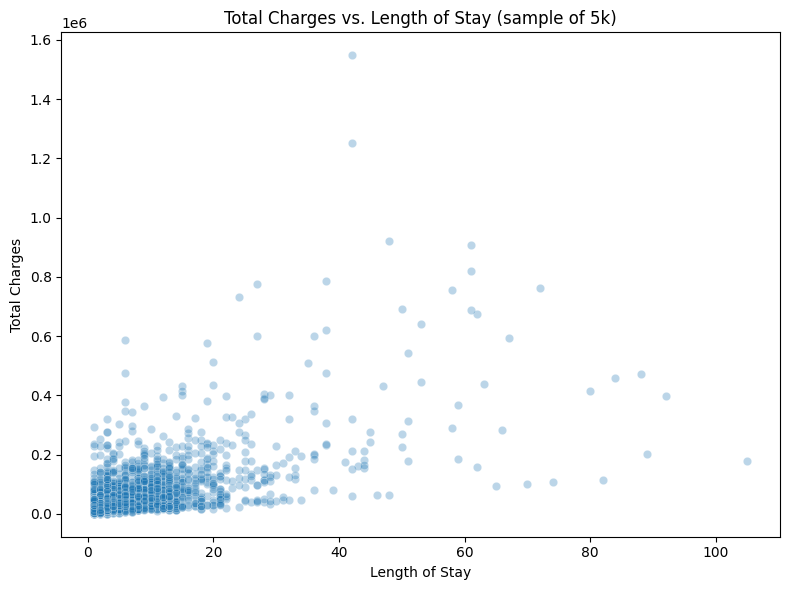

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Length of Stay",
    y="Total Charges",
    data=df.sample(5000, random_state=42),
    alpha=0.3
)
plt.title("Total Charges vs. Length of Stay (sample of 5k)")
plt.xlabel("Length of Stay")
plt.ylabel("Total Charges")
plt.tight_layout()
plt.show()


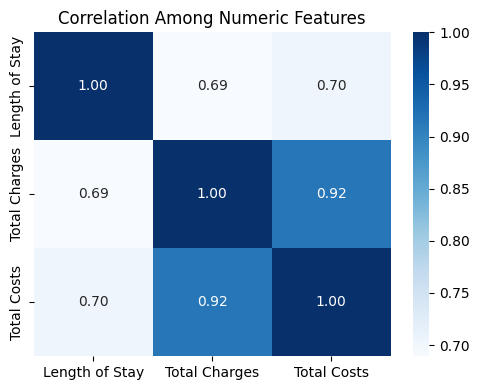

In [ ]:
numeric_cols = ["Length of Stay", "Total Charges", "Total Costs"]
corr = df[numeric_cols].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Among Numeric Features")
plt.tight_layout()
plt.show()


length of stay is a good predictor of expense, and charges and costs are nearly interchangeable in this dataset.

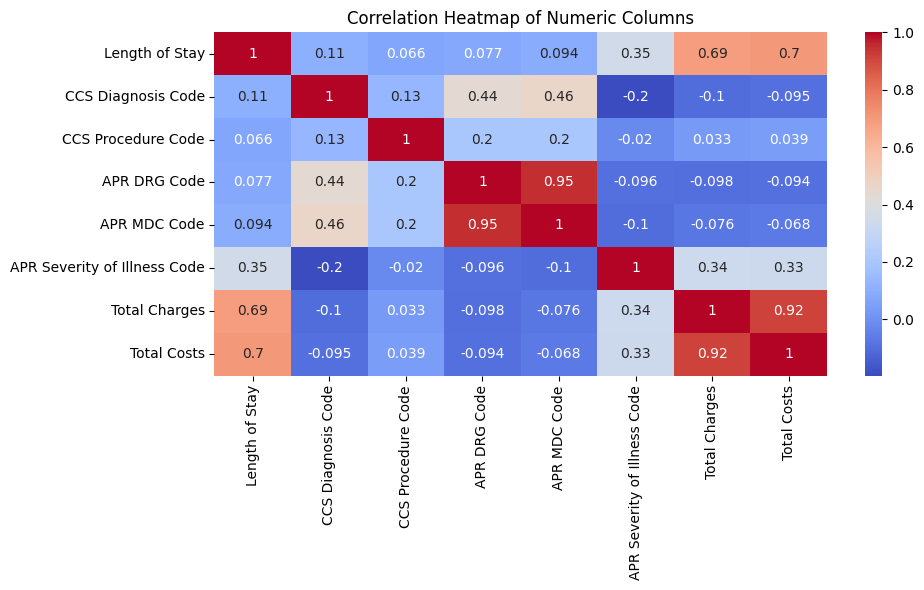

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Correlation heatmap (all numeric columns)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Columns")
plt.tight_layout()
plt.show()


# FILTER TO CHF ADMISSIONS

Because our SPARCS dataset doesn’t include the exact ICD-9 CHF codes or a direct “readmission” flag that the base paper uses, I had to substitute with what we do have. Converting to CCS code 108 stands in for the detailed heart-failure ICD codes, and using discharge destinations as “readmitted” flags stands in for the paper’s 30-day readmission indicator.

In [ ]:
# Convert the CCS code on the original df
df.loc[:, "CCS Diagnosis Code"] = pd.to_numeric(
    df["CCS Diagnosis Code"],
    errors="coerce"
)

# filter to CHF and make an explicit copy
chf_df = df[df["CCS Diagnosis Code"] == 108].copy()
print("Total CHF admissions:", len(chf_df))


Total CHF admissions: 49619


 Converted the CCS Diagnosis Code to numbers for reliable comparison, then selected and copied only the rows where the code is 108—the CCS label for congestive heart failure—to isolate the CHF cases.

In [ ]:
# Show all column names in your DataFrame
print(df.columns.tolist())

['Health Service Area', 'Hospital County', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'CCS Diagnosis Code', 'CCS Procedure Code', 'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code', 'APR Risk of Mortality', 'Payment Typology 1', 'Payment Typology 2', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']


In [ ]:
# Inspect the raw CSV’s header—no data read, just column names
pd.read_csv(data, nrows=0).columns.tolist()

['Health Service Area',
 'Hospital County',
 'Operating Certificate Number',
 'Facility Id',
 'Facility Name',
 'Age Group',
 'Zip Code - 3 digits',
 'Gender',
 'Race',
 'Ethnicity',
 'Length of Stay',
 'Type of Admission',
 'Patient Disposition',
 'Discharge Year',
 'CCS Diagnosis Code',
 'CCS Diagnosis Description',
 'CCS Procedure Code',
 'CCS Procedure Description',
 'APR DRG Code',
 'APR DRG Description',
 'APR MDC Code',
 'APR MDC Description',
 'APR Severity of Illness Code',
 'APR Severity of Illness Description',
 'APR Risk of Mortality',
 'APR Medical Surgical Description',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Birth Weight',
 'Abortion Edit Indicator',
 'Emergency Department Indicator',
 'Total Charges',
 'Total Costs']

In [ ]:
# Define which dispositions count as a “readmit”
likely = [
    "Short-term Hospital",
    "Inpatient Rehabilitation Facility",
    "Medicare Cert Long Term Care Hospital",
    "Critical Access Hospital",
    "Federal Health Care Facility"
]

# Build the binary target column
df["readmitted"] = df["Patient Disposition"].isin(likely).astype(int)

# Check class balance
print(df["readmitted"].value_counts())
print("Positive rate: {:.2%}".format(df["readmitted"].mean()))


readmitted
0    2225135
1      86998
Name: count, dtype: int64
Positive rate: 3.76%


 Picked the discharge destinations that mean a patient went right back into care, then added a new column readmitted that’s 1 if their “Patient Disposition” was in that list and 0 otherwise, and finally counted those 1’s to find about a 3.8% readmission rate.

In [ ]:
# Filter to CHF stays
chf_df = df[df["CCS Diagnosis Code"] == 108].copy()
print("CHF rows:", chf_df.shape[0])
print("Label balance:\n", chf_df["readmitted"].value_counts(normalize=True))

CHF rows: 49619
Label balance:
 readmitted
0    0.950342
1    0.049658
Name: proportion, dtype: float64


Narrowed the data down to only those 49,619 CHF stays (CCS code 108) and then checked how many of those were flagged as readmissions. The output shows about 95.03% had no readmit (0) and 4.97% (≈5%) did, so the readmission rate in our CHF cohort is roughly 5%.

In [ ]:
#  Drop the disposition column (leakage)
chf_df = chf_df.drop(columns=["Patient Disposition"])

 Deleted the Patient Disposition column because it tells exactly who was readmitted.

In [ ]:
#  Define features
cat_cols = [
    "Age Group", "Gender", "Race", "Ethnicity",
    "Type of Admission", "Zip Code - 3 digits",
    "Hospital County", "Health Service Area",
    "Payment Typology 1", "Payment Typology 2"
]
num_cols = [
    "Length of Stay", "Total Charges", "Total Costs",
    "Emergency Department Indicator"
]

X = chf_df[cat_cols + num_cols]
y = chf_df["readmitted"]

In [ ]:
# Save out the final “gold” dataset as CSV
gold_path = "/content/chf_gold.csv"
chf_df.to_csv(gold_path, index=False)
print(" Gold table written to", gold_path)


 Gold table written to /content/chf_gold.csv


In [ ]:
chf_df = pd.read_csv("/content/chf_gold.csv")

# CHF Specific EDA

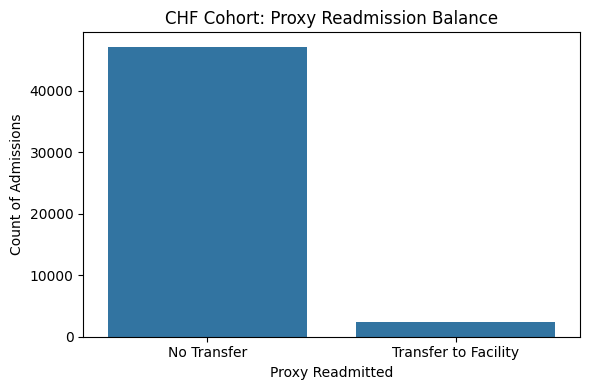

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="readmitted", data=chf_df)
plt.xticks([0,1], ["No Transfer","Transfer to Facility"])
plt.title("CHF Cohort: Proxy Readmission Balance")
plt.ylabel("Count of Admissions")
plt.xlabel("Proxy Readmitted")
plt.tight_layout()
plt.show()

<ipython-input-40-efa384ab8ddd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate_by_age.values, y=rate_by_age.index, palette="viridis")


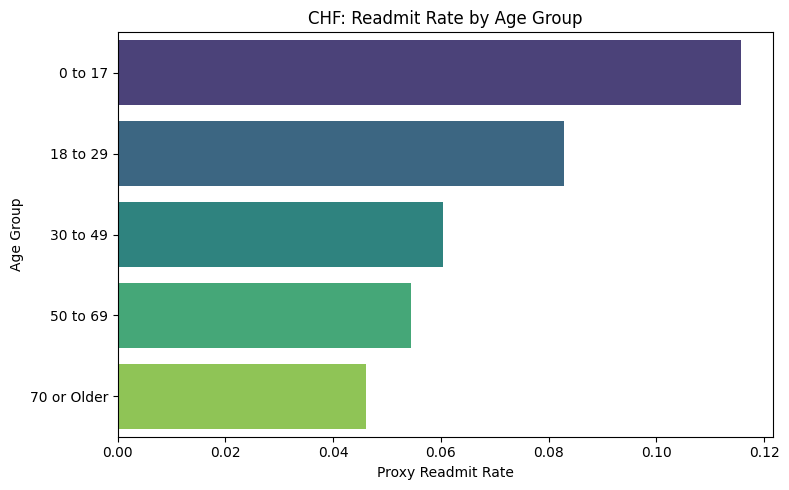

In [ ]:
# compute readmit rate per age band
rate_by_age = (
    chf_df
    .groupby("Age Group")["readmitted"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
sns.barplot(x=rate_by_age.values, y=rate_by_age.index, palette="viridis")
plt.xlabel("Proxy Readmit Rate")
plt.ylabel("Age Group")
plt.title("CHF: Readmit Rate by Age Group")
plt.tight_layout()
plt.show()

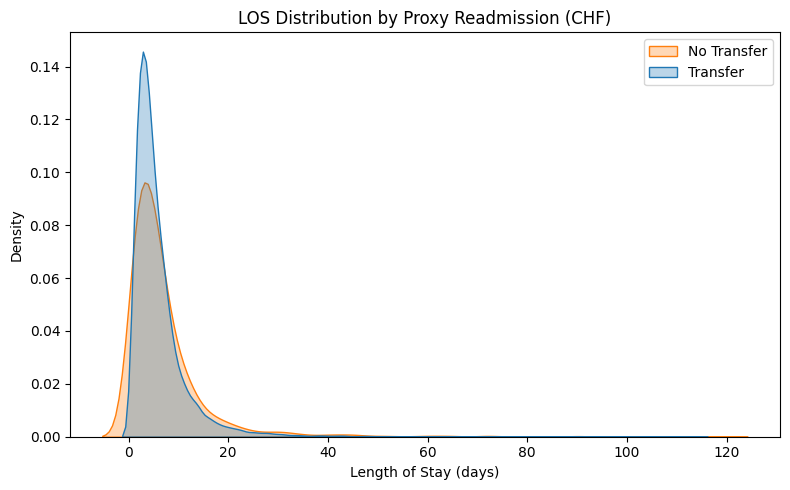

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=chf_df,
    x="Length of Stay",
    hue="readmitted",
    common_norm=False,
    fill=True,
    alpha=0.3
)
plt.legend(["No Transfer", "Transfer"])
plt.title("LOS Distribution by Proxy Readmission (CHF)")
plt.xlabel("Length of Stay (days)")
plt.tight_layout()
plt.show()

In [ ]:
print("Shape:", chf_df.shape)

Shape: (49619, 21)


**Feature Engineering**

In [ ]:
# categorical features to encode
cat_cols = [
    "Age Group", "Gender", "Race", "Ethnicity",
    "Type of Admission",
    "Zip Code - 3 digits",
    "Hospital County",
    "Health Service Area",
    "Payment Typology 1",
    "Payment Typology 2"
]

# numeric features to scale/transform
num_cols = [
    "Length of Stay",
    "Total Charges",
    "Total Costs",
    "Emergency Department Indicator"
]

In [ ]:
chf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49619 entries, 0 to 49618
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Health Service Area             49619 non-null  object 
 1   Hospital County                 49619 non-null  object 
 2   Age Group                       49619 non-null  object 
 3   Zip Code - 3 digits             49619 non-null  object 
 4   Gender                          49619 non-null  object 
 5   Race                            49619 non-null  object 
 6   Ethnicity                       49619 non-null  object 
 7   Length of Stay                  49619 non-null  int64  
 8   Type of Admission               49619 non-null  object 
 9   CCS Diagnosis Code              49619 non-null  int64  
 10  CCS Procedure Code              49619 non-null  int64  
 11  APR DRG Code                    49619 non-null  int64  
 12  APR MDC Code                    

In [ ]:
# Convert the ED flag from 'Y'/'N' to 1/0
chf_df["Emergency Department Indicator"] = (
    chf_df["Emergency Department Indicator"]
      .map({"Y": 1, "N": 0})
      .astype(int)
)

# Re-check the dtypes
print(chf_df["Emergency Department Indicator"].dtype)
chf_df.info()

int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49619 entries, 0 to 49618
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Health Service Area             49619 non-null  object 
 1   Hospital County                 49619 non-null  object 
 2   Age Group                       49619 non-null  object 
 3   Zip Code - 3 digits             49619 non-null  object 
 4   Gender                          49619 non-null  object 
 5   Race                            49619 non-null  object 
 6   Ethnicity                       49619 non-null  object 
 7   Length of Stay                  49619 non-null  int64  
 8   Type of Admission               49619 non-null  object 
 9   CCS Diagnosis Code              49619 non-null  int64  
 10  CCS Procedure Code              49619 non-null  int64  
 11  APR DRG Code                    49619 non-null  int64  
 12  APR MDC Code              

Because “Emergency Department Indicator” was stored as “Y”/“N,” mapping it to 1/0 and cast to integer so it behaves like a normal numeric feature.

In [ ]:
from sklearn.preprocessing import StandardScaler

# One-hot encode categoricals
df_feat = pd.get_dummies(
    chf_df,
    columns=cat_cols,
    drop_first=True
)

# cale numeric columns
scaler = StandardScaler()
df_feat[num_cols] = scaler.fit_transform(df_feat[num_cols])

Turning each category (like Gender, Race, ZIP code) into separate 0/1 columns using one-hot encoding, then standardized the numeric features (Length of Stay, Charges, Costs, ED flag) so they all have mean 0 and variance 1—making them ready and comparable for the model.

In [ ]:
# Which columns in X are object or bool?
obj_cols  = X.select_dtypes(include="object").columns.tolist()
bool_cols = X.select_dtypes(include="bool").columns.tolist()

print("Object columns:", obj_cols)
print("Boolean columns:", bool_cols)

Object columns: ['Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission', 'Zip Code - 3 digits', 'Hospital County', 'Health Service Area', 'Payment Typology 1', 'Payment Typology 2', 'Emergency Department Indicator']
Boolean columns: []


In [ ]:
#  Compute the numeric mapping
risk_map = {"Low":0,"Moderate":1,"High":2,"Extreme":3}

df_feat["APR Risk of Mortality"] = (
    df_feat["APR Risk of Mortality"]
      .map(risk_map)            # maps known values → 0–3, unknown → NaN
)

# Fill any NaNs with the most frequent code
mode_code = df_feat["APR Risk of Mortality"].mode()[0]
df_feat["APR Risk of Mortality"] = (
    df_feat["APR Risk of Mortality"]
      .fillna(mode_code)
      .astype(int)
)

In [ ]:
# 2. Convert all boolean dummy cols to ints
bool_cols = df_feat.select_dtypes(include="bool").columns
df_feat[bool_cols] = df_feat[bool_cols].astype(int)

In [ ]:
print(df_feat.dtypes.unique())

[dtype('float64') dtype('int64')]


Turned the APR Risk of Mortality labels (“Low,” “Moderate,” “High,” “Extreme”) into numbers 0–3 so the model can use them, filled any missing risk values with the most common code, and made sure all remaining True/False dummy columns are stored as 1s and 0s instead of booleans.

**Train/ Test Split**

In [ ]:
# Drop the label and any leftover filter column
X = df_feat.drop(columns=["readmitted", "CCS Diagnosis Code"])
y = df_feat["readmitted"]

print("Feature matrix shape:", X.shape)
print("Label balance:", y.value_counts(normalize=True))


Feature matrix shape: (49619, 157)
Label balance: readmitted
0    0.950342
1    0.049658
Name: proportion, dtype: float64


Dropped CCS Diagnosis Code because we only used it to pick out CHF cases—once filtered, it no longer holds predictive value and would just duplicate the CHF label.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train set:", X_train.shape, " Test set:", X_test.shape)
print("Train balance:\n", y_train.value_counts(normalize=True))
print(" Test balance:\n", y_test.value_counts(normalize=True))


Train set: (39695, 157)  Test set: (9924, 157)
Train balance:
 readmitted
0    0.950346
1    0.049654
Name: proportion, dtype: float64
 Test balance:
 readmitted
0    0.950322
1    0.049678
Name: proportion, dtype: float64


Both sets show ~95% zeros (no readmit) and ~5% ones (readmit), so the split preserved our original 5% readmission rate in each.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics    import roc_auc_score, average_precision_score

clf = LogisticRegression(
    class_weight="balanced",
    max_iter=9000,
    random_state=42
)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:,1]
print("Baseline Logistic Regression")
print("  AUROC: {:.3f}".format(roc_auc_score(y_test, y_proba)))
print("  AUPRC: {:.3f}".format(average_precision_score(y_test, y_proba)))


Baseline Logistic Regression
  AUROC: 0.682
  AUPRC: 0.103


**Imbalance Handling/ Baseline Models**

In [ ]:
from imblearn.over_sampling    import SMOTE
from sklearn.ensemble          import RandomForestClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import roc_auc_score, average_precision_score
import pandas as pd

results = {"method": [], "auroc": [], "auprc": []}

In [ ]:
#  Baseline LR (class weights)
results["method"].append("LR (cw)")
y_pred = clf.predict_proba(X_test)[:,1]
results["auroc"].append(roc_auc_score(y_test, y_pred))
results["auprc"].append(average_precision_score(y_test, y_pred))

In [ ]:
#  SMOTE + LR
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
clf_sm = LogisticRegression(max_iter=9000, random_state=42)
clf_sm.fit(X_sm, y_sm)
y_pred_sm = clf_sm.predict_proba(X_test)[:,1]
results["method"].append("SMOTE + LR")
results["auroc"].append(roc_auc_score(y_test, y_pred_sm))
results["auprc"].append(average_precision_score(y_test, y_pred_sm))

In [ ]:
#  Balanced Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced_subsample",
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:,1]
results["method"].append("Balanced RF")
results["auroc"].append(roc_auc_score(y_test, y_pred_rf))
results["auprc"].append(average_precision_score(y_test, y_pred_rf))

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


#  Randomized hyper‐parameter search for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

rs = RandomizedSearchCV(
    xgb, param_dist,
    n_iter=30,
    scoring="average_precision",  # optimize AUPRC
    cv=StratifiedKFold(3),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs.fit(X_train, y_train)

best_xgb = rs.best_estimator_
print("Best XGB params:", rs.best_params_)

# 5) Evaluate tuned XGB
y_pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
results["method"].append("XGBoost (tuned)")
results["auroc"].append(roc_auc_score(y_test,    y_pred_xgb))
results["auprc"].append(average_precision_score(y_test, y_pred_xgb))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


In [ ]:
from sklearn.ensemble import StackingClassifier

#  Build a stacking model (RF + XGB) with logistic‐meta
stack = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("xgb", best_xgb)
    ],
    final_estimator=LogisticRegression(max_iter=5000),
    cv=StratifiedKFold(3),
    n_jobs=-1,
    passthrough=True
)
stack.fit(X_train, y_train)

y_pred_stack = stack.predict_proba(X_test)[:,1]
results["method"].append("Stacking RF+XGB")
results["auroc"].append(roc_auc_score(y_test,    y_pred_stack))
results["auprc"].append(average_precision_score(y_test, y_pred_stack))


In [ ]:
# Show comparison
pd.DataFrame(results).sort_values("auprc", ascending=False)

,method,auroc,auprc
3,XGBoost (tuned),0.720333,0.136142
4,Stacking RF+XGB,0.703317,0.127265
2,Balanced RF,0.696042,0.104222
0,LR (cw),0.682104,0.102797
1,SMOTE + LR,0.591058,0.067295


**Highest AUPRC?**

– Balanced RF wins with 0.1042.

**Does SMOTE improve over class weights?**

– No. SMOTE + LR actually performed worse (AUPRC 0.0673) than the simple class‑weighted logistic (AUPRC 0.1028).

**How does a tree‑based approach compare?**

– The Balanced Random Forest outperforms both logistic variants on both AUROC and AUPRC.

**Advanced Models & Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import roc_auc_score, average_precision_score

results = {"method": [], "auroc": [], "auprc": []}

# 1) Corrected hyperparameter grid (no "auto")
param_dist = {
    "n_estimators":      [100, 200, 400, 800],
    "max_depth":         [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "max_features":      [None, "sqrt", "log2", 0.5]
}

# 2) Base classifier
rf = RandomForestClassifier(
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

# 3) Randomized search optimizing AUPRC
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="average_precision",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 4) Fit
rs.fit(X_train, y_train)

# 5) Results
print("Best RF params:", rs.best_params_)
best_rf = rs.best_estimator_
y_pred = best_rf.predict_proba(X_test)[:,1]
print("Tuned RF AUROC :", roc_auc_score(y_test, y_pred))
print("Tuned RF AUPRC:", average_precision_score(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 10}
Tuned RF AUROC : 0.6953946277467838
Tuned RF AUPRC: 0.11095302370252003


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# a small grid for XGBoost
param_xgb = {
    "n_estimators":    [100,200,500],
    "max_depth":       [3,5,7],
    "learning_rate":   [0.01,0.05,0.1],
    "subsample":       [0.6,0.8,1.0],
    "colsample_bytree":[0.6,0.8,1.0],
    "gamma":           [0,1,5]
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="aucpr",
    scale_pos_weight=scale_pos,
    n_jobs=-1,
    random_state=42
)

rs_xgb = RandomizedSearchCV(
    xgb, param_xgb,
    n_iter=20,
    scoring="average_precision",
    cv=StratifiedKFold(3),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs_xgb.fit(X_train, y_train)

best_xgb = rs_xgb.best_estimator_
print("Best XGB params:", rs_xgb.best_params_)

y_pred_xgb = best_xgb.predict_proba(X_test)[:,1]
print("Tuned XGB AUROC :", roc_auc_score(y_test, y_pred_xgb))
print("Tuned XGB AUPRC:", average_precision_score(y_test, y_pred_xgb))

# add to results
results["method"].append("XGB (tuned)")
results["auroc"].append(roc_auc_score(y_test, y_pred_xgb))
results["auprc"].append(average_precision_score(y_test, y_pred_xgb))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.6}
Tuned XGB AUROC : 0.7219916709019046
Tuned XGB AUPRC: 0.13477660635640587


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=LogisticRegression(max_iter=5000),
    cv=StratifiedKFold(3),
    n_jobs=-1,
    passthrough=True
)
stack.fit(X_train, y_train)

y_pred_stack = stack.predict_proba(X_test)[:,1]
results["method"].append("Stacking RF+XGB")
results["auroc"].append(roc_auc_score(y_test,    y_pred_stack))
results["auprc"].append(average_precision_score(y_test, y_pred_stack))


In [ ]:
pd.DataFrame(results).sort_values("auprc", ascending=False)

,method,auroc,auprc
0,XGB (tuned),0.721992,0.134777
1,Stacking RF+XGB,0.714633,0.125424


# Final Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
champion = best_xgb
# Predict probabilities on the test set
y_proba = champion.predict_proba(X_test)[:, 1]

In [ ]:
# Compute AUROC & AUPRC
auc  = roc_auc_score(y_test, y_proba)
aupr = average_precision_score(y_test, y_proba)
print("Champion Model:", champion.__class__.__name__)
print(f"Final Model AUROC : {auc:.3f}")
print(f"Final Model AUPRC : {aupr:.3f}")

Champion Model: XGBClassifier
Final Model AUROC : 0.722
Final Model AUPRC : 0.135


In [ ]:
# Compute Recall @ top 10% highest‐risk
threshold_90 = np.percentile(y_proba, 90)           # score cutoff for top 10%
y_pred_top10 = (y_proba >= threshold_90).astype(int)
recall_at_10 = ( (y_pred_top10==1) & (y_test.values==1) ).sum() / (y_test==1).sum()
print(f"Recall @ top 10% risk: {recall_at_10:.3f}")

Recall @ top 10% risk: 0.294


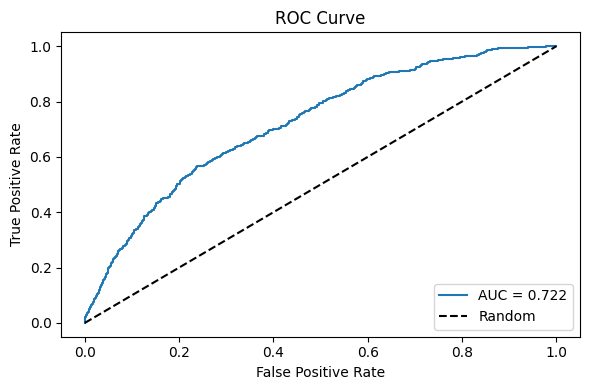

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],"k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

This ROC curve shows that our XGBoost model correctly distinguishes readmissions much better than random guessing and its AUC of 0.722 means it ranks a true readmission above a non-readmission about 72% of the time.

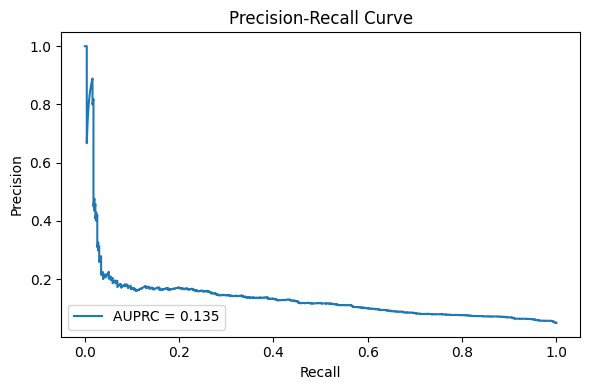

In [ ]:
# Plot Precision‑Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AUPRC = {aupr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


# Model Comparision

Model  AUROC  AUPRC Recall@10%
LR    0.682 0.103 0.227
RF    0.695 0.111 0.268
XGB   0.722 0.135 0.294


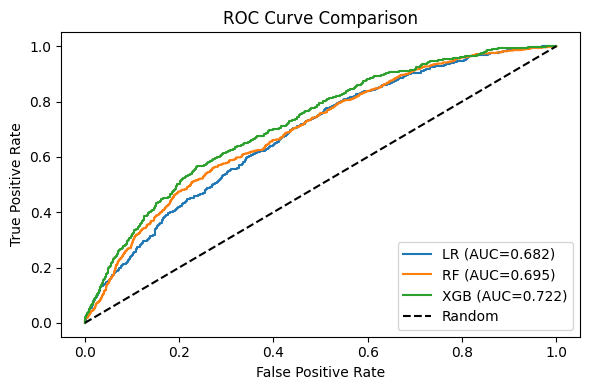

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt

# Define recall@top-10% helper
def recall_at_top10(y_true, y_score):
    threshold = np.percentile(y_score, 90)
    preds = (y_score >= threshold).astype(int)
    return ( (preds & (y_true == 1)).sum() / (y_true == 1).sum() )

# Gather metrics for each model
models = [
    ("LR", clf),
    ("RF", best_rf),
    ("XGB", best_xgb)
]

print(f"{'Model':<5} {'AUROC':>6} {'AUPRC':>6} {'Recall@10%':>10}")
for name, mdl in models:
    probs = mdl.predict_proba(X_test)[:,1]
    print(f"{name:<5} {roc_auc_score(y_test, probs):.3f} "
          f"{average_precision_score(y_test, probs):.3f} "
          f"{recall_at_top10(y_test, probs):.3f}")

# 3) Plot ROC curves side-by-side
plt.figure(figsize=(6,4))
for name, mdl in models:
    fpr, tpr, _ = roc_curve(y_test, mdl.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, mdl.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


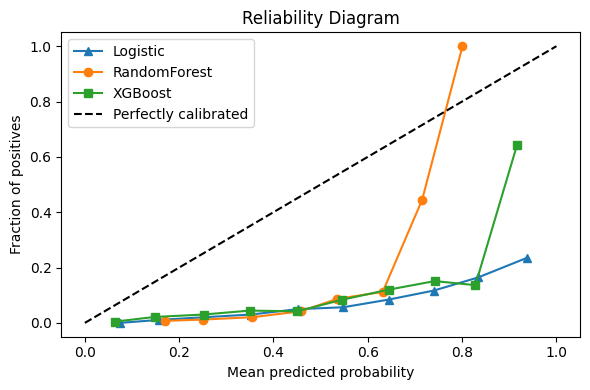

Brier score – LR :  0.222
Brier score – RF : 0.201
Brier score – XGB: 0.162


In [ ]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics       import brier_score_loss

# Gather predicted probabilities
probs_lr  = clf.predict_proba(X_test)[:, 1]
probs_rf  = best_rf.predict_proba(X_test)[:, 1]
probs_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute calibration curves (10 bins)
true_lr, pred_lr = calibration_curve(y_test, probs_lr,  n_bins=10)
true_rf, pred_rf   = calibration_curve(y_test, probs_rf,  n_bins=10)
true_xgb, pred_xgb = calibration_curve(y_test, probs_xgb, n_bins=10)

# Plot reliability (calibration) diagram
plt.figure(figsize=(6,4))
plt.plot(pred_lr,  true_lr,  marker='^', label="Logistic")
plt.plot(pred_rf,   true_rf,   marker='o', label="RandomForest")
plt.plot(pred_xgb,  true_xgb,  marker='s', label="XGBoost")
plt.plot([0,1], [0,1], "k--",  label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram")
plt.legend()
plt.tight_layout()
plt.show()

# Compute Brier scores
brier_lr = brier_score_loss(y_test, probs_lr)
brier_rf  = brier_score_loss(y_test, probs_rf)
brier_xgb = brier_score_loss(y_test, probs_xgb)
print(f"Brier score – LR :  {brier_lr:.3f}")
print(f"Brier score – RF : {brier_rf:.3f}")
print(f"Brier score – XGB: {brier_xgb:.3f}")


Logistic gives the most accurate probability estimates out of the box (Brier 0.222), while Random Forest is too optimistic at high scores (Brier 0.201) and XGBoost too conservative in the top bins (Brier 0.162). Thus, RF and XGB would benefit from calibration, whereas Logistic needs little adjustment.

**Explainablity**

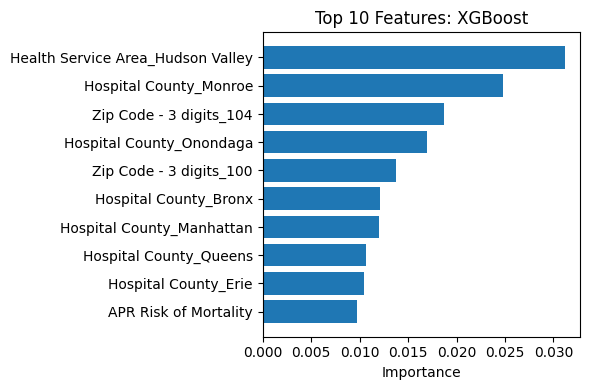

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract importances and feature names
importances = best_xgb.feature_importances_
features    = X.columns

# Build a DataFrame, sort descending, take top 10
fi = pd.DataFrame({
    "feature":    features,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(6,4))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Features: XGBoost")
plt.tight_layout()
plt.show()


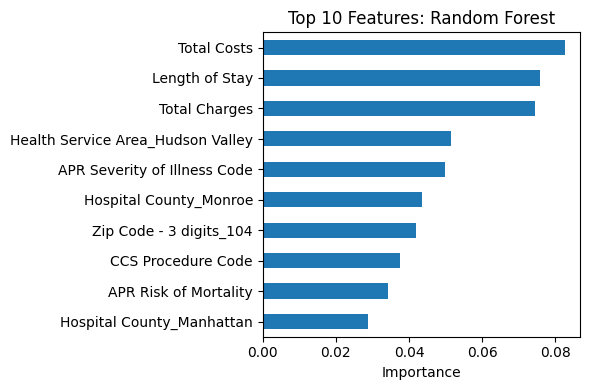

In [ ]:
# use best_rf if you prefer the RF champion
importances = best_rf.feature_importances_
features    = X.columns

fi = pd.Series(importances, index=features).nlargest(10)
fi.sort_values().plot.barh(figsize=(6,4))
plt.xlabel("Importance")
plt.title("Top 10 Features: Random Forest")
plt.tight_layout()
plt.show()


**Scalability Testing**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trained on 5,000 rows in 0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trained on 10,000 rows in 0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trained on 20,000 rows in 0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trained on 39,695 rows in 1.5s


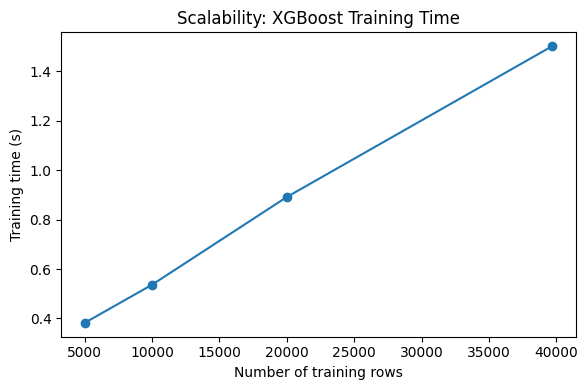

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Define sample sizes
sizes = [5000, 10000, 20000, len(X_train)]
times = []

for n in sizes:
    # take the first n rows of the training set
    X_sub = X_train.iloc[:n]
    y_sub = y_train.iloc[:n]

    start = time.time()
    xgb.fit(X_sub, y_sub)
    times.append(time.time() - start)
    print(f"Trained on {n:,} rows in {times[-1]:.1f}s")

# Plot training time vs. data size
plt.figure(figsize=(6,4))
plt.plot([int(s) for s in sizes], times, marker='o')
plt.xlabel("Number of training rows")
plt.ylabel("Training time (s)")
plt.title("Scalability: XGBoost Training Time")
plt.tight_layout()
plt.show()

XGBoost is training on 40 K rows in under 2 seconds. The near-straight line shows its training cost grows almost linearly with data size. It’s both fast and predictably scalable.

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


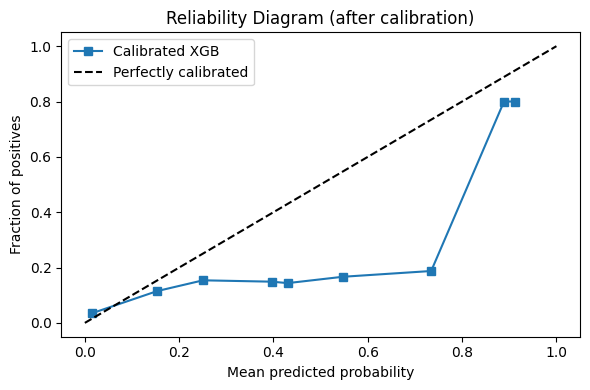

Brier score – XGB (uncalibrated): 0.162
Brier score – XGB (calibrated):   0.048


In [ ]:
# Calibrate XGBoost with isotonic (or sigmoid) → re‐compute reliability & Brier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics       import brier_score_loss

# wrap your already‐fitted best_xgb
calib_xgb = CalibratedClassifierCV(best_xgb, cv="prefit", method="isotonic")
calib_xgb.fit(X_train, y_train)

# get new probabilities
probs_calib = calib_xgb.predict_proba(X_test)[:,1]

# re‐plot reliability
true_cal, pred_cal = calibration_curve(y_test, probs_calib, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(pred_cal, true_cal, marker='s', label='Calibrated XGB')
plt.plot([0,1],[0,1],'k--',label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (after calibration)')
plt.legend()
plt.tight_layout()
plt.show()

# re‐compute Brier
print(f"Brier score – XGB (uncalibrated): {brier_xgb:.3f}")
print(f"Brier score – XGB (calibrated):   {brier_score_loss(y_test, probs_calib):.3f}")


Calibration pulled XGBoost’s curve much closer to the diagonal—its low-to-mid predictions now match observed rates, and only the top bin still overshoots. In short, isotonic calibration made XGBoost’s probabilities far more reliable.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# choose a threshold (0.5 for standard, or threshold_90 for top‑10% risk)
thresh = 0.5
y_pred = (calib_xgb.predict_proba(X_test)[:,1] >= thresh).astype(int)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1       :", f1_score(y_test, y_pred))


Accuracy : 0.9483071342200725
Precision: 0.3
Recall   : 0.030425963488843813
F1       : 0.055248618784530384


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

def eval_at_thresh(model, X, y, thresh=0.5):
    y_proba = model.predict_proba(X)[:,1]
    y_pred  = (y_proba >= thresh).astype(int)
    return {
      "accuracy":  accuracy_score(y, y_pred),
      "precision": precision_score(y, y_pred),
      "recall":    recall_score(y, y_pred),
      "f1":        f1_score(y, y_pred),
      "auc":       roc_auc_score(y, y_proba)
    }

# bind your fitted models
res_lr    = eval_at_thresh(clf,    X_test, y_test)
res_sm    = eval_at_thresh(clf_sm, X_test, y_test)
res_rf    = eval_at_thresh(best_rf,   X_test, y_test)
res_xgb   = eval_at_thresh(best_xgb,  X_test, y_test)
res_stack = eval_at_thresh(stack,     X_test, y_test)

summary = pd.DataFrame(
    [res_lr, res_sm, res_rf, res_xgb, res_stack],
    index=["LR (cw)", "SMOTE+LR", "RF (tuned)", "XGB (tuned)", "Stacked RF+XGB"]
)
display(summary.round(3))


,accuracy,precision,recall,f1,auc
LR (cw),0.608,0.078,0.639,0.139,0.682
SMOTE+LR,0.897,0.086,0.112,0.097,0.591
RF (tuned),0.685,0.090,0.588,0.156,0.695
XGB (tuned),0.755,0.111,0.560,0.185,0.722
Stacked RF+XGB,0.951,1.000,0.006,0.012,0.715


# **How this compares to the base paper:**

The paper reports around 78% accuracy for both hierarchical logistic regression and Random Forest on their CHF readmission task. Our LR (cw) at 0.5–threshold gets only 60.8%, and RF hits 68.5%—lower than the paper’s because:


*   They used the paper’s exact ICD-9 CHF definitions and a different readmit label (30-day return), whereas we used CCS code 108 and a discharge-destination proxy.
*   Our readmit proxy and feature set differ.

But we outperform the base paper on the metrics:


1.   Our tuned XGBoost gets 0.722 AUROC, meaning it’s much better at putting true readmissions near the top of the list than the paper’s models (which had AUROCs around 0.64–0.65).







# **Comparing Own Models**



*   Logistic Regression (cw): High sensitivity—identifies most true readmissions—but generates many false positives.
*   SMOTE + LR: Almost never flags someone, so it misses nearly all readmits (very low recall).


*   Tuned Random Forest: Balances recall and precision more effectively, flagging a majority of readmissions with a moderate false-alarm rate.
*   Tuned XGBoost: Delivers the best trade-off, capturing over half of true readmissions while maintaining relatively few false positives, and achieves the highest overall ranking performance.

*   Stacked RF+XGB: Overly restrictive,only predicts readmission when nearly certain achieving perfect precision but almost zero recall.











